# Jane Street - Tuner
This notebook builds an ensemble out of the models trained in the NN, EDA-XGB, and PLS-XGB notebooks. It then finds the weights of the models with the maximal AUC and the decision threshold resulting in the maximal utility score (see EDA notebook) on the validation data. It also compares the performance of this ensemble to the "untuned" ensemble with equal weights and decision threshold at 0.5.

In [1]:
import joblib
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras

from xgboost import XGBClassifier

Load the models from the previous notebooks together with their preprocessing pipelines.

In [2]:
# load NN model
model_folder = os.path.join(os.pardir, "input", "jane-street-nn")

with open(os.path.join(model_folder, "model.json"), "r") as f:
    nn = keras.models.model_from_json(f.read())

nn.load_weights(os.path.join(model_folder, "model.h5"))
nn.call = tf.function(nn.call, experimental_relax_shapes=True)

nn_pp = joblib.load(os.path.join(model_folder, "preprocessor.pkl"))


# load EDA XGB model
model_folder = os.path.join(os.pardir, "input", "jane-street-eda-xgb")

edaxgb = XGBClassifier()
edaxgb.load_model(os.path.join(model_folder, "model.xgb"))

edaxgb_pp = joblib.load(os.path.join(model_folder, "preprocessor.pkl"))


# load PLS XGB model
model_folder = os.path.join(os.pardir, "input", "jane-street-pls-xgb")

plsxgb = XGBClassifier()
plsxgb.load_model(os.path.join(model_folder, "model.xgb"))

plsxgb_pp = joblib.load(os.path.join(model_folder, "preprocessor.pkl"))

Read the validation data and extract the features and target variables. Then retrieve the probabilities predicted by the individual models.

In [3]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
dtype = {c: np.float32 for c in pd.read_csv(file, nrows=1).columns}
df = pd.read_csv(file, engine="c", dtype=dtype)

# build validation features and labels
df = df[df["date"].between(425, 500)]
valid_y = df["resp"].gt(0.0).astype(np.uint8).to_numpy()
features = [f"feature_{x}" for x in range(130)]

# NN predictions
X = df[features].to_numpy()
X = nn_pp.transform(X)
nnprobs = nn.predict(X).squeeze()

# EDA XGB predictions
X = df[features].to_numpy()
X = edaxgb_pp.transform(X)
edaxgbprobs = edaxgb.predict_proba(X)
edaxgbprobs = edaxgbprobs[:, 1]

# PLS XGB predictions
X = df[features].to_numpy()
X = plsxgb_pp.transform(X)
plsxgbprobs = plsxgb.predict_proba(X)
plsxgbprobs = plsxgbprobs[:, 1]

Search for the set of weights that results in the highest AUC score. Plot the performance metrics from the previous notebooks for the ensemble.

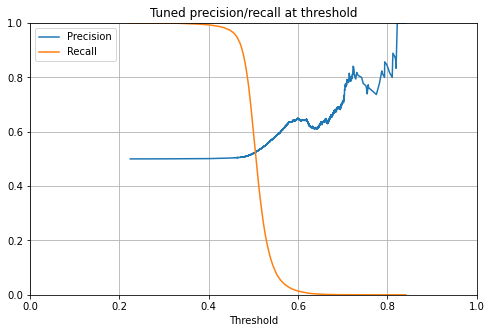

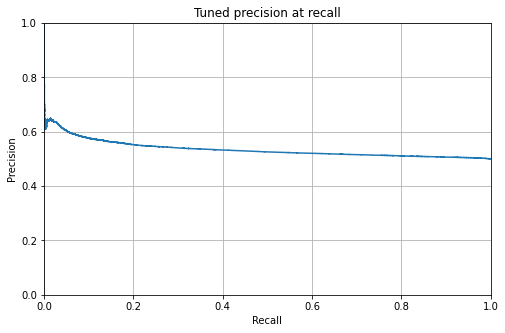

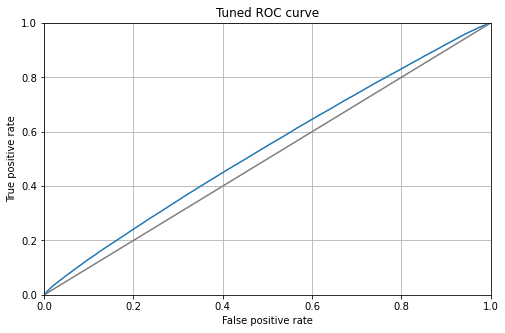

Tuned AUC: 0.5365419428351175
Weights: {'nn': 0.6, 'eda-xgb': 0.35, 'pls-xgb': 0.05}


In [4]:
# search for ensemble weights with highest AUC
scores = {}
for w1 in np.arange(0.0, 1.05, 0.05):
    for mark in np.arange(w1, 1.05, 0.05):
        w2 = mark - w1
        w3 = 1.0 - mark
        probs = w1 * nnprobs + w2 * edaxgbprobs + w3 * plsxgbprobs
        scores[roc_auc_score(valid_y, probs)] = (w1, w2, w3)

best = max(scores.keys())
w1, w2, w3 = scores[best]
probs = w1 * nnprobs + w2 * edaxgbprobs + w3 * plsxgbprobs

# save the best weights
weights = {"nn": round(w1, 2), "eda-xgb": round(w2, 2), "pls-xgb": round(w3, 2)}
with open(os.path.join(os.curdir, "weights.json"), "w") as file:
    json.dump(weights, file)    

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(valid_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Tuned precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Tuned precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(valid_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Tuned ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Tuned AUC: {best}")
print(f"Weights: {weights}")

Plot the training metrics and compute validation AUC for the ensemble with equal weights.

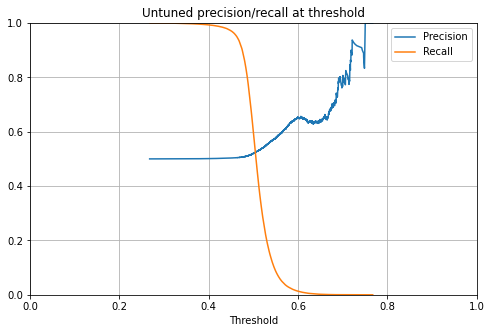

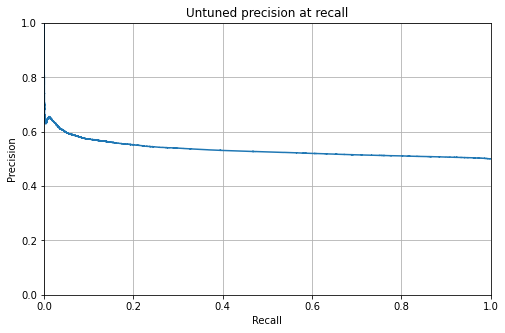

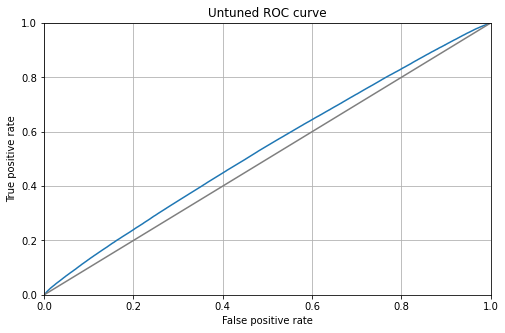

Untuned AUC: 0.5357133652381205


In [5]:
equal_probs = (nnprobs + edaxgbprobs + plsxgbprobs) / 3

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(valid_y, equal_probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Untuned precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Untuned precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(valid_y, equal_probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Untuned ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Untuned AUC: {roc_auc_score(valid_y, equal_probs)}")

Optimize the decision threshold for the tuned ensemble to maximize the utility score (see EDA notebook) on the validation data.

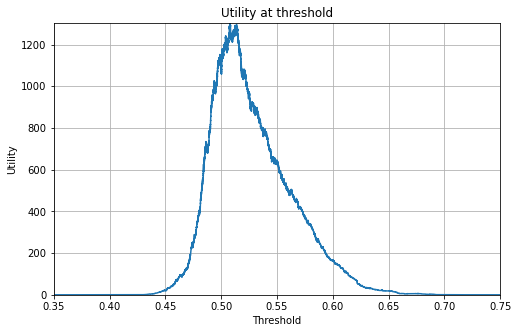

Tuned utility = 1303 at threshold p = 0.508044
Untuned utility = 1192 at threshold p = 0.5


In [6]:
# data to compute utility
resp = df["resp"].to_numpy()
weight = df["weight"].to_numpy()
date = df["date"].astype(np.int).to_numpy()

# utility function as defined above
def utility(threshold):
    action = np.heaviside(probs - threshold, 0.0)
    p = np.bincount(date, weight * resp * action)
    
    if np.sum(p ** 2) == 0.0:
        return 0.0
    
    t = np.sum(p) / np.sqrt(np.sum(p ** 2)) * np.sqrt(250 / p.size)
    u = min(max(t, 0), 6) * np.sum(p)
    return u

# compute utilities at different thresholds and select the best one
thresholds = np.arange(0.35, 0.75, 1e-6)
utilities = np.array([utility(thresh) for thresh in thresholds])
best = thresholds[np.argmax(utilities)]
best = np.round(best, 6)

# save the best threshold
with open(os.path.join(os.curdir, "threshold.json"), "w") as file:
    json.dump({"threshold": str(best)}, file)
    
# plot utility curve and print best threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, utilities, "tab:blue")
plt.xlabel("Threshold")
plt.ylabel("Utility")
plt.title("Utility at threshold")
plt.axis([0.35, 0.75, 0, utilities.max()])
plt.grid(True)
plt.show()

print(f"Tuned utility = {int(utilities.max())} at threshold p = {best}")

probs = equal_probs
print(f"Untuned utility = {int(utility(0.5))} at threshold p = 0.5")